# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [154]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


import warnings

warnings.filterwarnings('ignore')

# magic word for producing visualizations in notebook
%matplotlib inline

In [150]:
def treinar_modelo(modelo, X_train, y_train, cv, random_state, n_jobs=-1):
    '''
    Function to train a pipeline and returns the model's metrics
    Inputs
        modelo: model that will be trained
        X_train: x train data
        y_train: y train data
        cv: numbers of cv
        random_state: random state
        n_jobs: number of jobs
    Output:
        Returns a list with the model's metrics
        
    '''
    
    pipeline = Pipeline([modelo])
    resultado_cv = cross_validate(
                            estimator=pipeline, 
                            X=X_train,
                            y=y_train,
                            scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                            cv=cv,
                            n_jobs=-1)

    df_aux = pd.DataFrame(resultado_cv)
    dfar = df_aux.mean()

    return [
            dfar.loc['test_accuracy'], 
            dfar.loc['test_precision'], 
            dfar.loc['test_recall'], 
            dfar.loc['test_f1'], 
            dfar.loc['test_roc_auc']
    ]


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Data Preparation

In [2]:
# load in the data
azdias = pd.read_csv('azdias.csv', sep=',')
customers = pd.read_csv('customers.csv', sep=',')
df_atributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx',header = 1)

azdias = azdias.drop('Unnamed: 0', axis=1)
customers = customers.drop('Unnamed: 0', axis=1)

Como temos uma grande quantidade de colunas, **vamos remover todas as colunas que tenham mais do que 25% de valores missing**

In [3]:
# Analysing the missing data and getting % Null
df_azdias_columns= pd.DataFrame(azdias.isna().mean()).reset_index()
df_azdias_columns.columns = ['Attribute', '%null']
df_azdias_columns = pd.merge(df_atributes, df_azdias_columns, on='Attribute')
columns = list(df_azdias_columns[df_azdias_columns['%null'] <= 0.25]['Attribute'])

In [4]:
azdias = azdias[columns].dropna()
customers = customers[columns].dropna()

In [5]:
# Categorical data
category_columns = ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'OST_WEST_KZ']

# Converting to category data type

azdias[category_columns] = azdias[category_columns].astype('category')
customers[category_columns] = customers[category_columns].astype('category')

# Creating dummies to all categorical features
azdias_treated = pd.get_dummies(azdias)
customers_treated = pd.get_dummies(customers)


### Análise Exploratória

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Dendogram

A dendrogram is a graphical representation of a hierarchical structure. It is commonly used in cluster analysis to show how individual elements or groups of elements are clustered with each other. Dendrograms are particularly useful in multivariate data analysis, such as in statistics and bioinformatics.



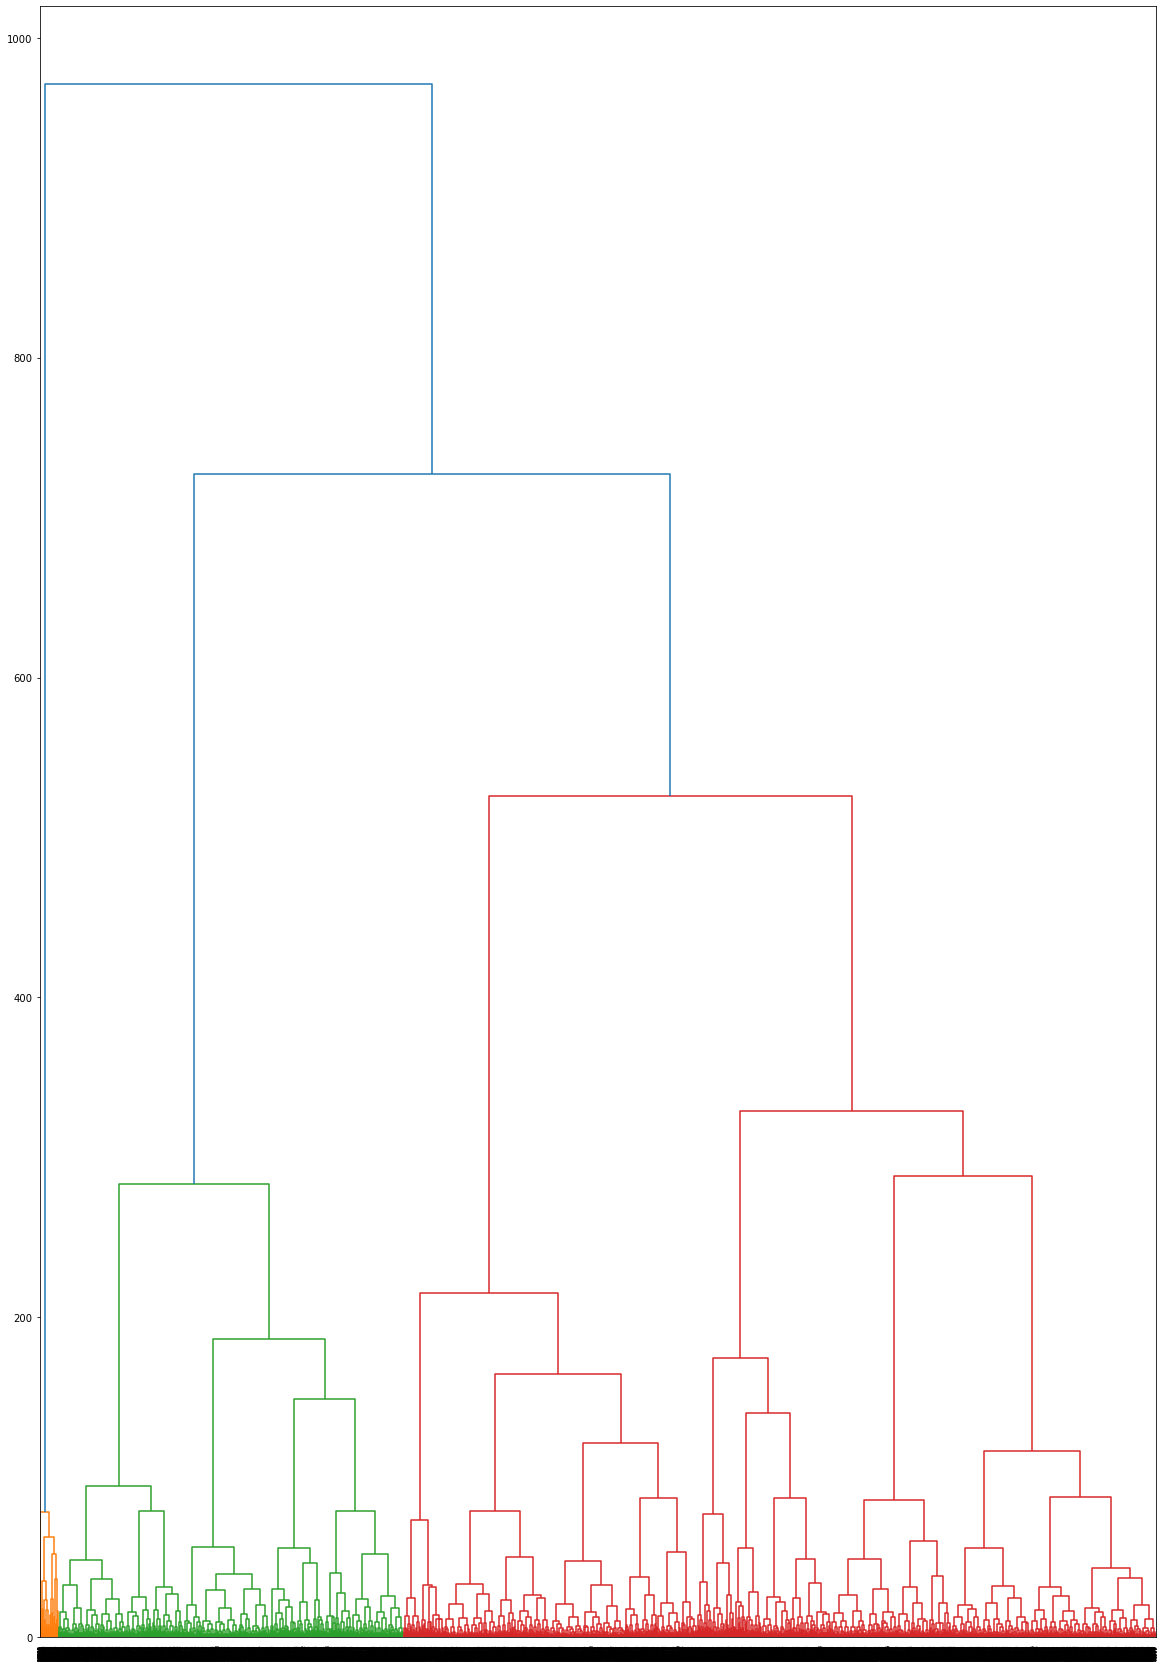

In [6]:
pca = make_pipeline(StandardScaler(), PCA(n_components=3, random_state=123))
X_reduced = pd.DataFrame(pca.fit_transform(azdias_treated), columns=['pc1', 'pc2','pc3'])
fig, ax = plt.subplots(figsize=(20, 30))
ax.grid(False)
cluster_aglo = hierarchy.linkage(X_reduced.sample(20000), method='ward') 

dend = hierarchy.dendrogram(cluster_aglo)

### Elbow Method

The elbow method is a technique used in cluster analysis to determine the optimal number of clusters in a dataset. The idea behind this method is to observe the variation of the sum of intra-cluster squares concerning the number of clusters. The "elbow" point in the graph of this variation suggests the optimal number of clusters, where adding more clusters does not provide significant gains in reducing intra-cluster variance.






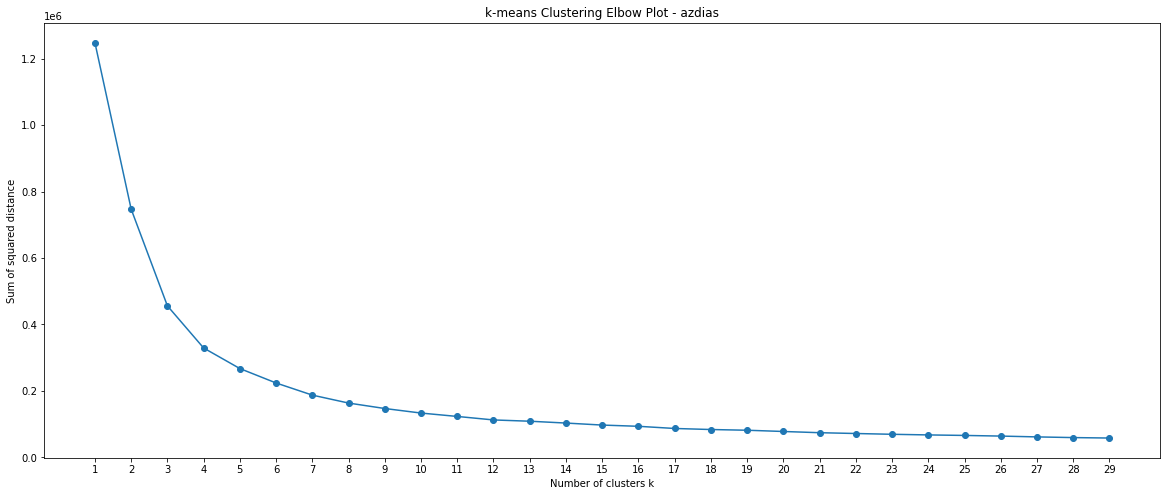

In [7]:
# Usando o método do cotovelo, também conhecido como Elbow Method

# A classe KElbowVisualizer implementa o método "elbow" para selecionar o número ótimo de clusters para o KMeans.
from sklearn.cluster import KMeans

model = KMeans()

sse = []
list_k = list(range(1, 30))

for k in list_k:
    km = KMeans(n_clusters=k, init='k-means++')
    km.fit(X_reduced.sample(20000))
    sse.append(km.inertia_)
    
# Plot sse against k
plt.figure(figsize=(20, 8))
plt.plot(list_k, sse, '-o')
plt.title('k-means Clustering Elbow Plot - azdias')
plt.xlabel("Number of clusters k")
plt.ylabel("Sum of squared distance")
plt.xticks(list(range(1,30)))
plt.show()


As we can see in the dendrogram and elbow visualizations below, we will select **7 clusters** to create the model.

## Machine Learning Pipeline

#### Kmeans Model

The K-Means algorithm is a popular method for clustering data, widely used in machine learning and data mining. Its main purpose is to divide a dataset into k groups (clusters) based on the similarity of elements.

#### Principal Component Analysis

Principal Component Analysis (PCA) is a statistical technique used for dimensionality reduction in complex datasets. The main goal is to transform a set of correlated variables into a set of uncorrelated variables, known as principal components. These components capture most of the variance present in the original data.



### Standard Scaler

The Standard Scaler is a data preprocessing technique used in statistical analysis and machine learning to standardize the features of a dataset. Standardization involves transforming the features so that they have a mean of zero and a standard deviation of one. This means that the data is adjusted to follow a normal distribution with a mean of zero and a standard deviation of one.

The standardization process is important when the features in the dataset have different scales, which can adversely affect scale-sensitive machine learning algorithms. By applying the Standard Scaler, features are rescaled so that they all have the same scale, making the data comparable.



In [65]:
pca_components = pipeline.named_steps['pca']
kmeans = pipeline.named_steps['kmeans']
transformer =  pipeline.named_steps['standard_scaler']


In [8]:
pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('pca', PCA(n_components=3, random_state = 1)),
    ('kmeans', KMeans(n_clusters=7, random_state=30, init = 'k-means++'))
]
)
pipeline.fit(azdias_treated)

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('pca', PCA(n_components=3, random_state=1)),
                ('kmeans', KMeans(n_clusters=7, random_state=30))])

In [9]:
# Predict cluster using population data
cluster = pipeline.predict(azdias_treated)

### Surrogate Tree Tecnichque

The Surrogate Tree method involves training a decision tree to understand the most important variables within the clusters

In [10]:
clf = DecisionTreeClassifier(random_state=30)
clf.fit(azdias_treated, cluster)

DecisionTreeClassifier(random_state=30)

In [11]:
top_features = pd.Series(clf.feature_importances_, index=azdias_treated.columns).sort_values(ascending=False).head(15).index.tolist()

<AxesSubplot:>

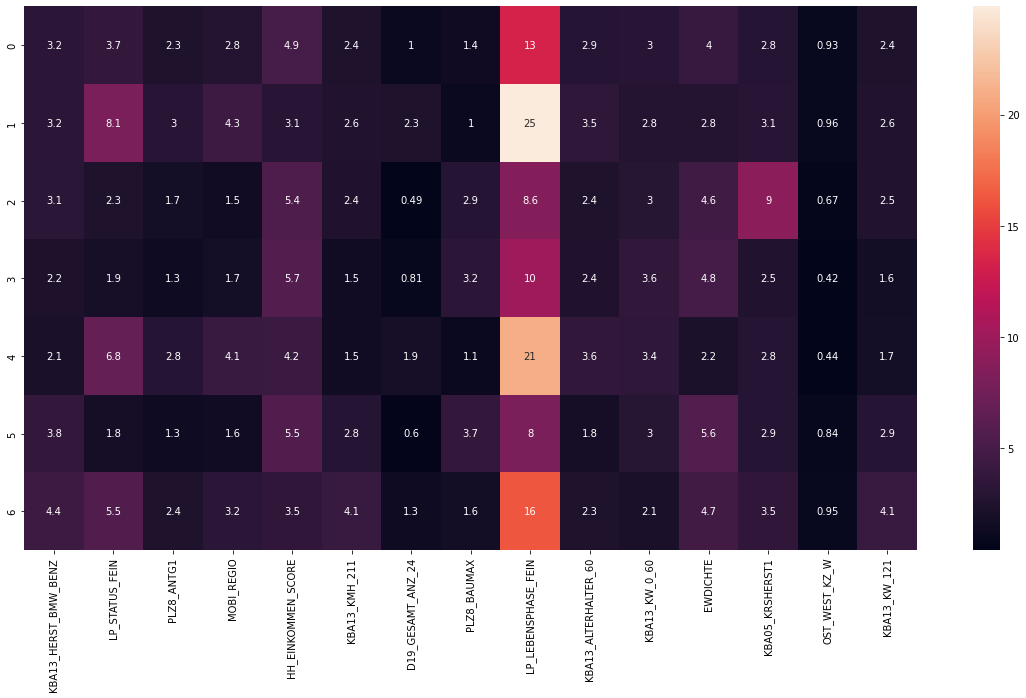

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.heatmap(azdias_treated.groupby(pipeline.named_steps['kmeans'].labels_).mean()[top_features].round(2), ax=ax, annot=True)

### Visualization of Cluster Populations

In [32]:
#columns_ = list(azdias_treated.drop('Cluster', axis=1))
customers_treated = customers_treated[columns_]

In [33]:
azdias_treated['Cluster'] = pipeline.predict(azdias_treated[columns_]) +1 
customers_treated['Cluster'] = pipeline.predict(customers_treated) +1

In [35]:
customer_clustered = customers_treated['Cluster'].value_counts().sort_index()
polulation_clustered = azdias_treated['Cluster'].value_counts().sort_index()

In [ ]:
Analisando os clusters mais propensos 

In [37]:
clusters = pd.concat([polulation_clustered, customer_clustered], axis=1)
clusters.columns = ['Population', 'Customer']
clusters['% Population / Customer'] = clusters['Customer'] / clusters['Population'] * 100
clusters

,Population,Customer,% Population / Customer
1,151321,18116,11.971901
2,161906,57101,35.267995
3,12353,664,5.375212
4,105983,4276,4.034609
5,79099,8997,11.374354
6,108383,8003,7.383999
7,78814,26085,33.096912


Abaixo podemos ver a distibuição dos 7 clusters em relação a base de dados. Conseguimos notar que os clusters que possuem a maior concentração de clientes são os clusters 1, 2 e 7.

O Perfil desses clusters está segmentado dessa forma

| ---- | Cluster 1 |Cluster 2 | Cluster 7 |
|---|---|---|---|
| Transaction activity TOTAL POOL in the last 24  | 1 |  2 | 1 |
| Total POOL in the last 24 months   | 5 |  3 | 5 |
| Density of inhabitants per square kilometer | 5 |  2 | 2 |
| Estimated household net income | 3 |  3 | 4 |
| Share of Mercedes/BMW (reffered to the county average)  | 3 |  3 | 2 |
| Share of car owners between 46 and 60 within the PLZ8  | 3 |  3 | 5 |
| Share of BMW & Mercedes Benz within the PLZ8	  | 3 |  3 | 4 |
| Share of cars with a greater max speed than 210 km/h within the PLZ8  | 15|  36 | 20 |
| Share of cars up to 60 KW engine power - PLZ8	  | 4 |  10 | 9 |
| Share of cars with an engine power more than 120 KW - PLZ8 | 3 |  4 | 4 |
| Single low-income earners of younger age | 1 |  1 | 1 |
| Number of 1-2 family houses in the PLZ8 | 2 |  3 | 2 |
| Most common building-type within the PLZ8  | 1 |  1 | 1 |    

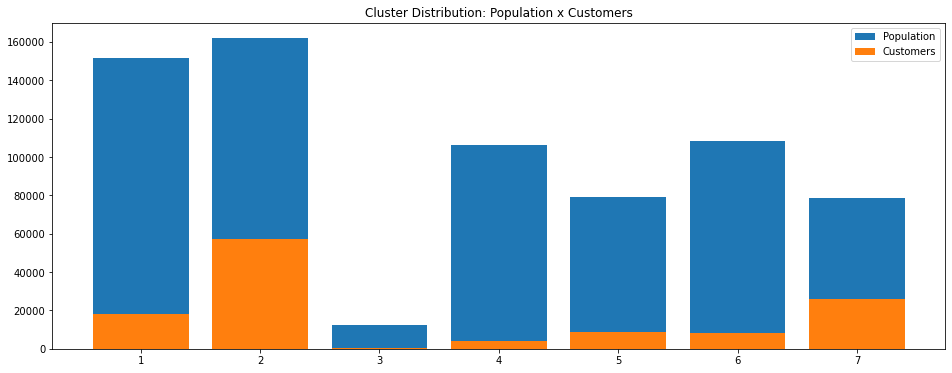

In [75]:
fig, ax = plt.subplots(figsize=(16,6))
plt.title('Cluster Distribution: Population x Customers')
visualization_population = ax.bar(clusters.index, clusters['Population'], bottom=0)
visualization_customer = ax.bar(clusters.index, clusters['Customer'], bottom=0)
ax.legend((visualization_population[0], visualization_customer[0]), ('Population', 'Customers'))
plt.show()

In [ ]:
customers_treated_agg[customers_treated_agg['Cluster'].isin([1,2,7])].T.reset_index()

,index,0,1,6
0,Cluster,1.0,2.0,7.0
1,D19_GESAMT_ANZ_24,1.0,2.0,1.0
2,EWDICHTE,5.0,3.0,5.0
3,HH_EINKOMMEN_SCORE,5.0,2.0,2.0
4,KBA05_KRSHERST1,3.0,3.0,4.0
5,KBA13_ALTERHALTER_60,3.0,3.0,2.0
6,KBA13_HERST_BMW_BENZ,3.0,3.0,5.0
7,KBA13_KMH_211,3.0,3.0,4.0
8,KBA13_KW_0_60,3.0,3.0,2.0
9,KBA13_KW_121,3.0,3.0,4.0


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [87]:
# Reading train and test data
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';').drop('Unnamed: 0', axis=1)
mailout_teste = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';').drop('Unnamed: 0', axis=1)

### Data Preparation

In [100]:
# Getting all the columns with <= 25 % missing data
mailout_columns = pd.DataFrame(mailout_train.isna().sum() / mailout_train.shape[0]).reset_index()
mailout_columns.columns = ['column', '%null']
columns = list(mailout_columns[mailout_columns['%null'] <= 0.25]['column'].values)

#### Removing NA values from our data

In [102]:
mailout_train = mailout_train[columns].dropna()

#### Adjusting data type from categorical data

In [124]:
mailout_train_categorical = mailout_train.select_dtypes('object').columns
mailout_train['EINGEFUEGT_AM'] = pd.to_datetime(mailout_train['EINGEFUEGT_AM'], format='%Y-%m-%d ').dt.year
mailout_train[mailout_train_categorical] = mailout_train[mailout_train_categorical].astype('category')
mailout_train_treated = pd.get_dummies(mailout_train)

In [160]:
mailout_teste['EINGEFUEGT_AM'] = pd.to_datetime(mailout_teste['EINGEFUEGT_AM'], format='%Y-%m-%d ').dt.year
mailout_teste[mailout_train_categorical] = mailout_teste[mailout_train_categorical].astype('category')
mailout_teste = pd.get_dummies(mailout_train)

#### Getting X and Y data

In [132]:
X_train = mailout_train_treated.drop('RESPONSE', axis=1)
Y_train = mailout_train_treated.RESPONSE

In [161]:
X_test = mailout_teste.drop('RESPONSE', axis=1)
Y_test = mailout_teste.RESPONSE

We have a completely unbalanced database with a distribution of 98.7% to 1.3%. If we train the model without balancing, it will only be able to make accurate predictions for one class.

Because of this, we'll need to balance the classes to achieve good results for both. To do this, we'll employ the randomized under-sampling technique.

In [215]:
Y_train.value_counts(normalize= True) * 100

0    98.686136
1     1.313864
Name: RESPONSE, dtype: float64

#### Under-sampling

In [195]:
rus = RandomUnderSampler(replacement=True)
X_rus, y_rus = rus.fit_resample(X_train, Y_train)

## Data Modeling

With our data prepared, we will proceed to train the following models: DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier, XGBClassifier, LGBMClassifier, and CatBoostClassifier. We will evaluate which model demonstrates better performance in predicting whether or not a person became a customer of the company following the campaign.


#### Machine learning Pipeline

In [196]:
random_state = 142
modelos_arvores = [
    ('decision_tree', DecisionTreeClassifier(random_state=random_state)),
    ('random_forest', RandomForestClassifier(random_state=random_state)),
    ('gb', GradientBoostingClassifier(random_state=random_state)),
    ('xgb', XGBClassifier(random_state=random_state)),
    ('lgbm', LGBMClassifier(random_state=random_state)),
    ('catboost', CatBoostClassifier(random_state=random_state))
]


df_resultados = pd.DataFrame(columns=['acuracidade', 'precision', 'recall', 'f1', 'roc_auc'])


#### Training Model

In [198]:
%%time
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)


for model in modelos_arvores:
    model_name = model[0]
    print(f'Treinando {model_name} ...', end=' ')
    aux = treinar_modelo(model, X_rus, y_rus, skf, random_state)
    df_resultados.loc[model_name] = aux
    print('OK')

Treinando decision_tree ... OK
Treinando random_forest ... OK
Treinando gb ... OK
Treinando xgb ... OK
Treinando lgbm ... OK
Treinando catboost ... OK
Wall time: 1min 13s


#### Results

We can observe that after training the models, the CatBoost model exhibited the best performance in identifying whether or not a person became a customer of the company following the campaign. Therefore, we will select this model.

In [199]:
df_resultados

,acuracidade,precision,recall,f1,roc_auc
decision_tree,0.655467,0.665327,0.626740,0.644629,0.655378
random_forest,0.683829,0.697134,0.655511,0.674693,0.742677
gb,0.744734,0.723464,0.792674,0.756285,0.783322
xgb,0.731814,0.730265,0.738495,0.732814,0.786134
lgbm,0.762874,0.744503,0.803130,0.772149,0.797234
catboost,0.771931,0.739317,0.841891,0.787148,0.796654


In [200]:
# Melhor modelo foi o Catboost, logo:

best_model = Pipeline([modelos_arvores[-1]])
best_model.fit(X_train, Y_train)

Learning rate set to 0.04363
0:	learn: 0.6052013	total: 53.9ms	remaining: 53.8s
1:	learn: 0.5297071	total: 102ms	remaining: 50.7s
2:	learn: 0.4645789	total: 150ms	remaining: 49.7s
3:	learn: 0.4086539	total: 212ms	remaining: 52.7s
4:	learn: 0.3611361	total: 275ms	remaining: 54.7s
5:	learn: 0.3208782	total: 323ms	remaining: 53.5s
6:	learn: 0.2864808	total: 367ms	remaining: 52.1s
7:	learn: 0.2570533	total: 428ms	remaining: 53.1s
8:	learn: 0.2316893	total: 497ms	remaining: 54.7s
9:	learn: 0.2101539	total: 557ms	remaining: 55.2s
10:	learn: 0.1918111	total: 606ms	remaining: 54.5s
11:	learn: 0.1759238	total: 676ms	remaining: 55.7s
12:	learn: 0.1623440	total: 739ms	remaining: 56.1s
13:	learn: 0.1506797	total: 802ms	remaining: 56.5s
14:	learn: 0.1406433	total: 858ms	remaining: 56.3s
15:	learn: 0.1309917	total: 926ms	remaining: 56.9s
16:	learn: 0.1234467	total: 982ms	remaining: 56.8s
17:	learn: 0.1169428	total: 1.04s	remaining: 56.8s
18:	learn: 0.1113182	total: 1.09s	remaining: 56.3s
19:	learn: 

Pipeline(steps=[('catboost',
                 <catboost.core.CatBoostClassifier object at 0x000001FCC901A670>)])

In [216]:
### Predicting the test data
y_pred_oot = best_model.predict(X_test)
y_proba_oot = best_model.predict_proba(X_test)[:,1]
roc_auc_oot = roc_auc_score(Y_test, y_proba_oot)
print(f'RoC-AUC: {roc_auc_oot:.3f}')

RoC-AUC: 1.000


In [203]:
from sklearn import metrics

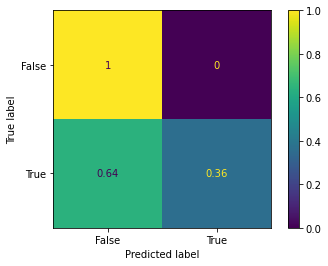

In [221]:
cm = metrics.confusion_matrix(Y_test,y_pred_oot, normalize = 'true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

### Shap test

In [206]:
import shap

explainer = shap.TreeExplainer(best_model[-1])
shap_values = explainer.shap_values(X_test)

### Conclusions

We were able to train a model that can identify 36% of the people who became customers following the campaign. Another point is that below are the most relevant pieces of information that contributed to the model's outcome.


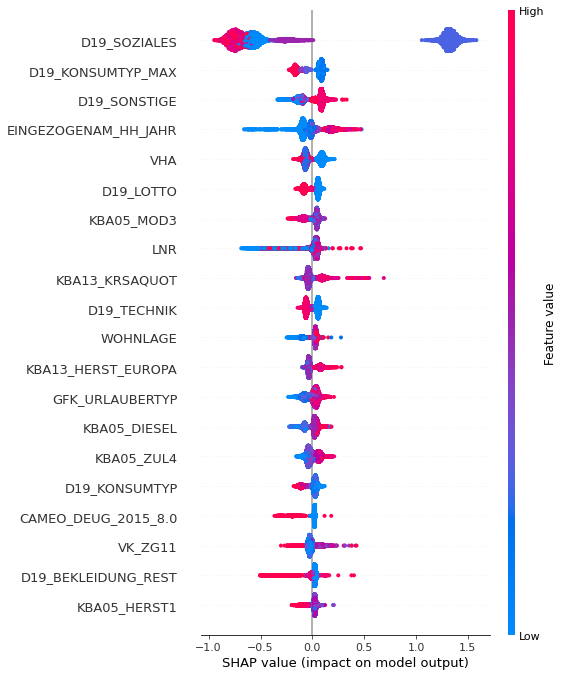

In [207]:
shap.summary_plot(shap_values, X_test).